In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('raw_data.csv')

/var/folders/6s/jysjm2tx6y90mh4fg5yj89lc0000gn/T/ipykernel_42676/1354964530.py:1: DtypeWarning: Columns (7,34) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('raw_data.csv')


In [3]:
data.head()

,date,time,race_distance,race_type,race_class,surface_name,default_condition,horse_number_1,runner_odds_1,morning_odds_1,...,horse_last_class_2,horse_num_races_2,early_2,middle_2,finish_2,jockey_trainer_starts_2,jockey_trainer_1st_2,jockey_trainer_2nd_2,jockey_trainer_3rd_2,result
0,2022-03-22,12:33 PM,6f,Thoroughbred,Claiming,Dirt,Fast,1,4,3,...,60,10.0,5.2,5.0,3.7,39,2,4,5,0
1,2022-03-22,12:33 PM,6f,Thoroughbred,Claiming,Dirt,Fast,1,4,3,...,64,10.0,8.5,8.1,4.7,12,1,2,2,0
2,2022-03-22,12:33 PM,6f,Thoroughbred,Claiming,Dirt,Fast,1,4,3,...,76,10.0,6.4,6.0,4.9,19,3,2,2,0
3,2022-03-22,12:33 PM,6f,Thoroughbred,Claiming,Dirt,Fast,1,4,3,...,65,8.0,4.9,5.3,4.0,28,3,1,6,1
4,2022-03-22,12:33 PM,6f,Thoroughbred,Claiming,Dirt,Fast,1,4,3,...,64,10.0,6.6,6.4,5.8,13,1,0,1,0


In [75]:
from sklearn.model_selection import train_test_split

X = data.iloc[:,:-1]
y = data['result']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=40)

In [76]:
Xs = { 'X_train': X_train, 'X_val': X_val }

for name, Xi in Xs.items():
    # date, time - convert to cycles
    date_time = (Xi['date'] + ' ' + Xi['time']).apply(lambda x: dt.datetime.strptime(
        x, '%Y-%m-%d %I:%M %p'))
    def date_to_nth_day(date):
        new_year_day = pd.Timestamp(year=date.year, month=1, day=1)
        return (date - new_year_day).days + 1
    def nth_day_to_cycle(n):
        radians = n*(2*np.pi)/(365.25)
        return np.cos(radians), np.sin(radians)
    Xi['date_cos'] = date_time.apply(lambda x: nth_day_to_cycle(date_to_nth_day(x))[0])
    Xi['date_sin'] = date_time.apply(lambda x: nth_day_to_cycle(date_to_nth_day(x))[1])
    def mins_to_cycle(mins):
        radians = mins*(2*np.pi)/(60*24)
        return np.cos(radians), np.sin(radians)
    Xi['time_cos'] = date_time.apply(lambda x: mins_to_cycle(x.hour*60 + x.minute)[0])
    Xi['time_sin'] = date_time.apply(lambda x: mins_to_cycle(x.hour*60 + x.minute)[1])
    Xi.drop(['date','time'], axis=1, inplace=True)

    # race_distance - standardize units to meters
    def conv_dist(dist):
        dist_to_meters = {'f': 201.168,
                          'mtr': 1,     # mtr (meter) comes before m (mile) in search
                          'm': 1609.34,
                          'y': 0.9144}
        for k,v in dist_to_meters.items():
            if k in dist:
                return float(dist[:-len(k)]) * v
    Xi['race_distance_meters'] = Xi['race_distance'].apply(lambda x: conv_dist(x))
    Xi.drop(['race_distance'], axis=1, inplace=True)

    # race_type - one-hot encode
    def fixed_one_hot(df, column, categories):
        for c in categories:
            df[c] = (df[column] == c)*1
    fixed_one_hot(Xi, 'race_type', ['Thoroughbred', 'Harness', 'Mixed', 'QuarterHorse', 'Arabian'])
    Xi.drop(['race_type'], axis=1, inplace=True)

    # race_class (TODO)
    Xi.drop(['race_class'], axis=1, inplace=True)

    # surface_name - one-hot encode
    fixed_one_hot(Xi, 'surface_name', ['Turf', 'Dirt', 'Synthetic', 'Downhill Turf', 'Steeplechase'])
    Xi.drop(['surface_name'], axis=1, inplace=True)

    # default_condition (TODO - see if there's a relationship e.g. good > good to soft > soft)
    Xi.drop(['default_condition'], axis=1, inplace=True)

    for i in ['1','2']:
        # horse number (TODO - normalize somehow. also has ints and strings.)
        Xi.drop(['horse_number_'+i], axis=1, inplace=True)

        # runner odds - drop
        Xi.drop(['runner_odds_'+i], axis=1, inplace=True)

        # morning odds - drop
        Xi.drop(['morning_odds_'+i], axis=1, inplace=True)

        # horse name (TODO)
        Xi.drop(['horse_name_'+i], axis=1, inplace=True)

        # horse age - as is

        # horse gender (TODO - a bunch of different "genders")
        Xi.drop(['horse_gender_'+i], axis=1, inplace=True)

        # horse siredam
        Xi.drop(['horse_siredam_'+i], axis=1, inplace=True)

        # horse med - drop
        Xi.drop(['horse_med_'+i], axis=1, inplace=True)

        # horse trainer (TODO)
        Xi.drop(['trainer_'+i], axis=1, inplace=True)

        # horse weight - convert to int and fill na with mean.
        def str_to_int(x):
            return int(x) if x.isdigit() else np.nan
        weight_ints = Xi['horse_weight_'+i].apply(lambda x: str_to_int(x.replace(' ','')))
        Xi['jockey_weight_'+i] = weight_ints.fillna(weight_ints.mean())
        Xi.drop(['horse_weight_'+i], axis=1, inplace=True)

        # horse jockey (TODO)
        Xi.drop(['jockey_'+i], axis=1, inplace=True)

        # horse power rating - convert to int and fill na with mean.
        power_ints = Xi['horse_power_rating_'+i].apply(lambda x: str_to_int(x.replace(' ','')))
        Xi['horse_power_rating_'+i] = power_ints.fillna(power_ints.mean())

        # horse wins/starts (TODO - handle confidence with increasing number of starts)
        Xi.drop(['horse_wins/starts_'+i], axis=1, inplace=True)

        # horse days off - convert to int and fill na with mean.
        days_off_ints = Xi['horse_days_off_'+i].apply(lambda x: str_to_int(x.replace(' ','')))
        Xi['horse_days_off_'+i] = days_off_ints.fillna(days_off_ints.mean())

        # avg speed - convert to int and fill na with mean.
        avg_speed_ints = Xi['horse_avg_speed_'+i].apply(lambda x: str_to_int(x.replace(' ','')))
        Xi['horse_avg_speed_'+i] = avg_speed_ints.fillna(avg_speed_ints.mean())

        # avg distance - convert to int and fill na with mean.
        avg_distance_ints = Xi['horse_avg_distance_'+i].apply(lambda x: str_to_int(x.replace(' ','')))
        Xi['horse_avg_distance_'+i] = avg_distance_ints.fillna(avg_distance_ints.mean())

        # high speed - convert to int and fill na with mean.
        high_speed_ints = Xi['horse_high_speed_'+i].apply(lambda x: str_to_int(x.replace(' ','')))
        Xi['horse_high_speed_'+i] = high_speed_ints.fillna(high_speed_ints.mean())

        # avg class - convert to int and fill na with mean.
        avg_class_ints = Xi['horse_avg_class_'+i].apply(lambda x: str_to_int(x.replace(' ','')))
        Xi['horse_avg_class_'+i] = avg_class_ints.fillna(avg_class_ints.mean())

        # last class - convert to int and fill na with mean.
        last_class_ints = Xi['horse_last_class_'+i].apply(lambda x: str_to_int(x.replace(' ','')))
        Xi['horse_last_class_'+i] = last_class_ints.fillna(last_class_ints.mean())

        # num races - as is

        # early - as is

        # middle - as is

        # finish - as is

        # starts - as is

        # 1st - as is

        # 2nd - as is

        # 3rd - as is
        
    Xs[name] = Xi

In [77]:
Xs['X_train'].head()

,horse_age_1,horse_power_rating_1,horse_days_off_1,horse_avg_speed_1,horse_avg_distance_1,horse_high_speed_1,horse_avg_class_1,horse_last_class_1,horse_num_races_1,early_1,...,Mixed,QuarterHorse,Arabian,Turf,Dirt,Synthetic,Downhill Turf,Steeplechase,jockey_weight_1,jockey_weight_2
79638,9.0,56.096866,17.0,52.000000,44.000000,55.000000,66.000000,68.000000,10.0,6.0,...,0,0,0,0,1,0,0,0,122.0,122.0
16014,5.0,56.096866,16.0,66.000000,65.000000,80.000000,82.000000,80.000000,4.0,3.8,...,0,0,0,0,1,0,0,0,124.0,124.0
14166,5.0,56.096866,13.0,86.000000,86.000000,96.000000,95.000000,97.000000,10.0,3.9,...,0,0,0,0,1,0,0,0,124.0,118.0
54731,5.0,56.096866,23.0,68.000000,67.000000,82.000000,87.000000,86.000000,8.0,6.5,...,0,0,0,0,1,0,0,0,122.0,122.0
83742,4.0,56.096866,16.0,68.166203,63.468122,75.957577,77.630104,78.777988,0.0,0.0,...,0,0,0,1,0,0,0,0,130.0,125.0


In [56]:
Xs['X_train'].isna().sum()

horse_age_1                0
horse_power_rating_1       0
horse_days_off_1           0
horse_avg_speed_1          0
horse_avg_distance_1       0
horse_high_speed_1         0
horse_avg_class_1          0
horse_last_class_1         0
horse_num_races_1          0
early_1                    0
middle_1                   0
finish_1                   0
jockey_trainer_starts_1    0
jockey_trainer_1st_1       0
jockey_trainer_2nd_1       0
jockey_trainer_3rd_1       0
horse_age_2                0
horse_power_rating_2       0
horse_days_off_2           0
horse_avg_speed_2          0
horse_avg_distance_2       0
horse_high_speed_2         0
horse_avg_class_2          0
horse_last_class_2         0
horse_num_races_2          0
early_2                    0
middle_2                   0
finish_2                   0
jockey_trainer_starts_2    0
jockey_trainer_1st_2       0
jockey_trainer_2nd_2       0
jockey_trainer_3rd_2       0
date_cos                   0
date_sin                   0
time_cos      

# Playground - reducing skew

In [19]:
import matplotlib.pyplot as plt

In [156]:
from scipy import stats

def str_is_float(x):
    try:
        float(x)
        return True
    except ValueError:
        return False
def str_to_float(x):
    return float(x) if str_is_float(x) else np.nan
def normalize(x, u, s):
    return (x - u)/s
def frac_top(x):
    parts = x.replace(' ','').split('/')
    return float(parts[0])
def frac_bot(x):
    parts = x.replace(' ','').split('/')
    return float(parts[1])
def eval_frac(x):
    if isinstance(x, int) or isinstance(x, float):
        return float(x)
    if "/" in x:
        parts = x.split("/")
        if float(parts[1]) == 0:
            return 0
        return float(parts[0]) / float(parts[1])
    return float(x)
def stf(df):
    return df.apply(lambda x: str_to_float((x if isinstance(x, str) else str(x)).replace(' ','')))

def custom_hist(ints, title):
    mini, maxi = np.min(ints), np.max(ints)
    plt.figure(figsize=(5, 2))
    plt.hist(ints, bins=np.arange(mini, maxi, (maxi-mini)/20))
    plt.title(title)
    plt.show()

def visualize_skew(ints):
    u, s = np.mean(ints), np.std(ints)
    
    print('skew:', ints.skew())
    print('skew after log:', np.log(ints).skew())
    print('skew after sqrt:', np.sqrt(ints).skew())
    print('skew after cube root:', np.power(ints, 1/3).skew())
#     print('skew after boxcox:', pd.Series(stats.boxcox(ints)[0]).skew())
    print('skew after square:', np.power(ints,2).skew())
    
    custom_hist(ints, 'original')
    
    print('mean:', u, ', std:', s)
    
    return ints
def visualize_normal(d):
    u, s = np.mean(d), np.std(d)
    dn = normalize(thing, u, s)
    
    custom_hist(dn, 'normalized')
    print('mean:', u, ', std:', s)

### age - log

skew: 1.0625418165381035
skew after log: 0.13535255717913716
skew after sqrt: 0.5888958467247695
skew after cube root: 0.4366455725681044
skew after square: 2.141035514732343


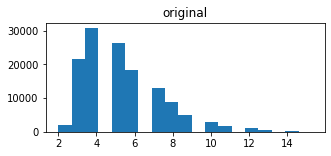

mean: 5.383343373493976 , std: 2.1190308713895303


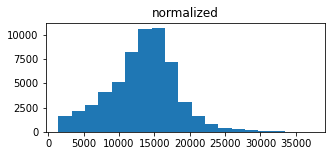

mean: 1.611377826671145 , std: 0.3770414294488063


In [194]:
df = stf(data['horse_age_1'])
d = visualize_skew(df)
transformed = np.log(d)
visualize_normal(transformed)

### weight - log

skew: 1.4450631565057663
skew after log: 1.3020507851401584
skew after sqrt: 1.374458069468201
skew after cube root: 1.350532649398425
skew after square: 1.5817095060162452


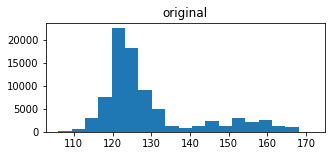

mean: 129.11204743313044 , std: 12.726909167639672


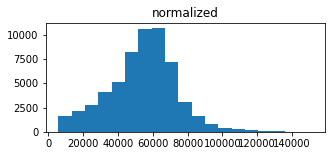

mean: 4.856201520634625 , std: 0.09277710202327677


In [165]:
df = stf(data['horse_weight_1'])
d = visualize_skew(df)
transformed = np.log(d)
visualize_normal(transformed)

### power rating - square

skew: -0.7892773410519449
skew after log: -1.643580238298235
skew after sqrt: -1.1948650044557896
skew after cube root: -1.3389233710979487
skew after square: -0.04926880745515666


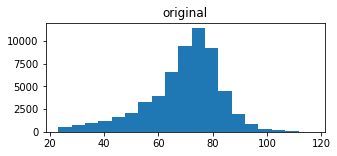

mean: 69.45932203389829 , std: 13.847426765202824


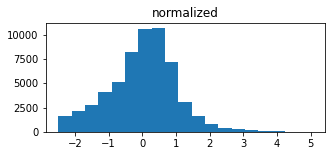

mean: 5016.348645426446 , std: 1795.9921702105964


In [140]:
df = stf(data['horse_power_rating_1'])
d = visualize_skew(df)
transformed = np.power(d, 2)
visualize_normal(transformed)

### wins/starts - cube root for all 3

In [157]:
horse_winrate = data['horse_wins/starts_'+i].apply(lambda x: eval_frac(x))
horse_wins = data['horse_wins/starts_'+i].apply(lambda x: frac_top(x))
horse_starts = data['horse_wins/starts_'+i].apply(lambda x: frac_bot(x))

skew: 3.2051072231415616
skew after log: nan
skew after sqrt: 1.1750974346430654
skew after cube root: 0.8808811632742368
skew after square: 9.813821325731551


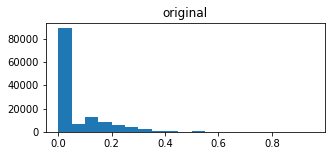

mean: 0.06597261076110704 , std: 0.12329410154493747


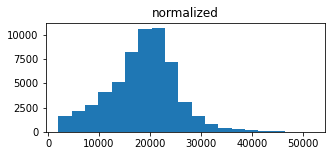

mean: 0.18887229260656888 , std: 0.2711806069214066


In [158]:
d = visualize_skew(horse_winrate)
transformed = np.power(d, 1/3)
visualize_normal(transformed)

skew: 3.382476962457077
skew after log: nan
skew after sqrt: 1.8035213392432807
skew after cube root: 1.2813034543275903
skew after square: 7.415185277923721


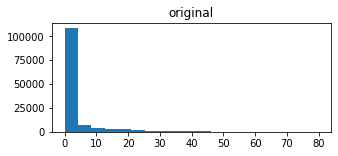

mean: 3.3223042168674697 , std: 7.885121500403579


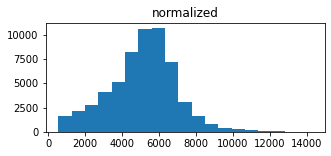

mean: 0.6365188073005978 , std: 0.9832922957293507


In [160]:
d = visualize_skew(horse_wins)
transformed = np.power(d, 1/3)
visualize_normal(transformed)

skew: 3.2307943232707275
skew after log: nan
skew after sqrt: 1.7318593765630026
skew after cube root: 1.1529778811609257
skew after square: 6.391825752347986


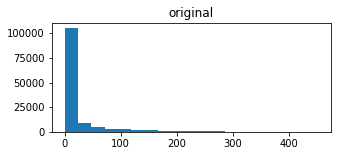

mean: 21.844849397590362 , std: 50.027480345669574


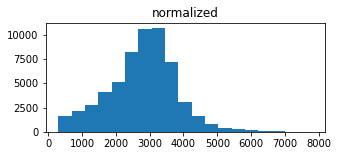

mean: 1.3166101445255058 , std: 1.8016120091512144


In [163]:
d = visualize_skew(horse_starts)
transformed = np.power(d, 1/3)
visualize_normal(transformed)

### days off - log

skew: 5.722381767873786
skew after log: 0.8684448564707075
skew after sqrt: 2.5256911741524735
skew after cube root: 1.8797356039977593
skew after square: 18.859209747615402


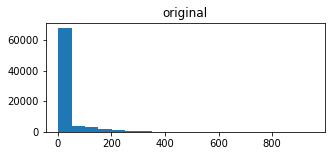

mean: 34.85192473718958 , std: 63.159593082460624


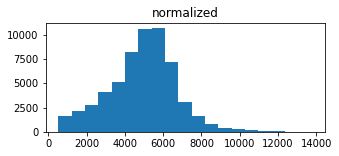

mean: 2.8840755872152273 , std: 1.020260399049755


In [141]:
df = stf(data['horse_days_off_1'])
d = visualize_skew(df)
transformed = np.log(d)
visualize_normal(transformed)

### avg speed - square

skew: -0.969151657209963
skew after log: -2.906738094672419
skew after sqrt: -1.607196500265081
skew after cube root: -1.9221298566156393
skew after square: -0.22442276403914768


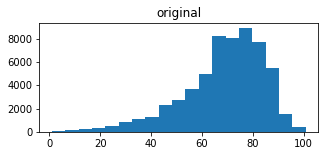

mean: 68.37891602144133 , std: 16.091744157083365


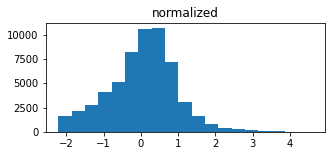

mean: 4934.620386284353 , std: 1985.5559651803374


In [142]:
df = stf(data['horse_avg_speed_1'])
d = visualize_skew(df)
transformed = np.power(d,2)
visualize_normal(transformed)

### avg distance - square

skew: -0.4304384386294315
skew after log: -1.9552853158165706
skew after sqrt: -0.9899575334826227
skew after cube root: -1.2382373322089648
skew after square: 0.3391223510385645


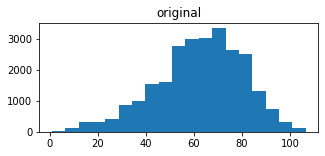

mean: 62.54477323649849 , std: 18.16069300997624


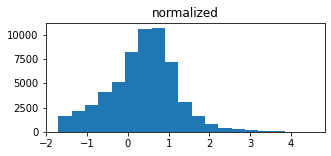

mean: 4241.659429807618 , std: 2174.677151306234


In [143]:
df = stf(data['horse_avg_distance_1'])
d = visualize_skew(df)
transformed = np.power(d,2)
visualize_normal(transformed)

### high speed - square

skew: -0.9843706960967346
skew after log: -2.8737391687743554
skew after sqrt: -1.6642153312925752
skew after cube root: -1.980774060506396
skew after square: -0.14809077284799108


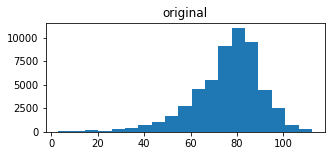

mean: 75.88112800623448 , std: 14.874552801691513


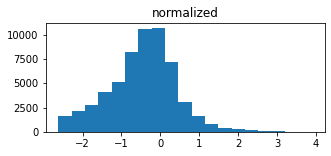

mean: 5979.197908548852 , std: 2073.8239849606457


In [144]:
df = stf(data['horse_high_speed_1'])
d = visualize_skew(df)
transformed = np.power(d,2)
visualize_normal(transformed)

### avg class - no skew reduction

skew: -0.2493321368691744
skew after log: -1.0215164061703075
skew after sqrt: -0.5502100429930757
skew after cube root: -0.676048449638142
skew after square: 0.236465497758258


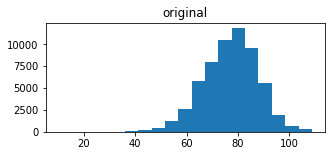

mean: 77.11999388566187 , std: 10.521634877199917


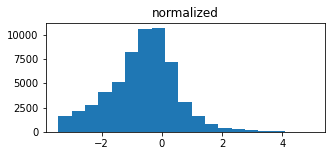

mean: 6058.198257413635 , std: 1604.538503308611


In [145]:
df = stf(data['horse_avg_class_1'])
d = visualize_skew(df)
transformed = np.power(d,2)
visualize_normal(transformed)

### last class - no skew reduction

skew: -0.24380791595718784
skew after log: -1.1055856420427692
skew after sqrt: -0.5940609464872146
skew after cube root: -0.736275358636574
skew after square: 0.32284355220422345


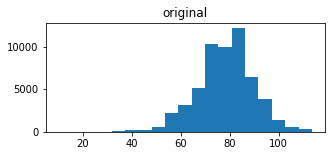

mean: 78.21593280282936 , std: 11.46674447715718


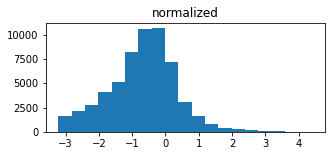

mean: 6249.218373121132 , std: 1774.6120239404127


In [146]:
df = stf(data['horse_last_class_1'])
d = visualize_skew(df)
transformed = np.power(d,2)
visualize_normal(transformed)

### early - sqrt

skew: 0.6363991049310506
skew after log: -0.5910472926809454
skew after sqrt: 0.030535058611420515
skew after cube root: -0.16810445460680573
skew after square: 2.633591866723278


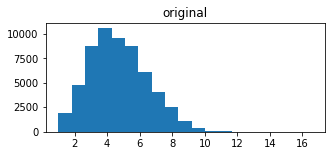

mean: 4.72146997331339 , std: 1.824497222623094


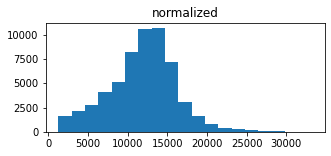

mean: 2.131388448313969 , std: 0.42267393544807175


In [185]:
df = stf(data['early_1']).replace(0, np.nan)
d = visualize_skew(df)
transformed = np.sqrt(d)
visualize_normal(transformed)

### middle - sqrt

skew: 0.5512888342416863
skew after log: -0.6522665969443884
skew after sqrt: -0.023966255058272747
skew after cube root: -0.22216436799363737
skew after square: 2.1186762580798053


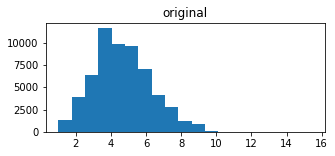

mean: 4.640023117064134 , std: 1.6488285053226905


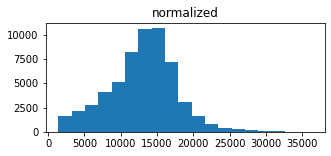

mean: 2.1191038092670085 , std: 0.38655162994636016


In [186]:
df = stf(data['middle_1']).replace(0, np.nan)
d = visualize_skew(df)
transformed = np.sqrt(d)
visualize_normal(transformed)

### finish - sqrt

skew: 0.45579281776129504
skew after log: -1.1386817825318731
skew after sqrt: -0.24698915075792163
skew after cube root: -0.5186831539341876
skew after square: 1.6251028202895619


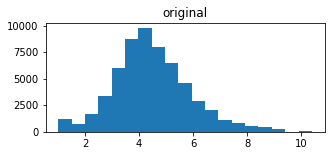

mean: 4.4720795444888255 , std: 1.445734694587513


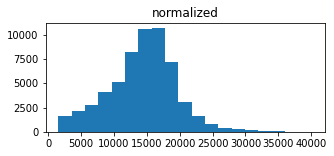

mean: 2.0855172954453436 , std: 0.3502815366061491


In [187]:
df = stf(data['finish_1']).replace(0, np.nan)
d = visualize_skew(df)
transformed = np.sqrt(d)
visualize_normal(transformed)

### starts - log

skew: 3.41848986721763
skew after log: 0.086165369238822
skew after sqrt: 1.760993630259879
skew after cube root: 1.1947944071803074
skew after square: 6.087718517007955


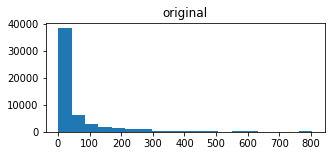

mean: 65.30026723102031 , std: 122.12617156616734


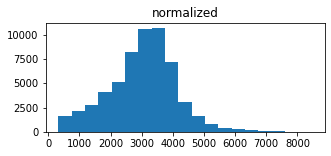

mean: 2.9269913008286803 , std: 1.6593574214464766


In [189]:
df = stf(data['jockey_trainer_starts_1']).replace(0, np.nan)
d = visualize_skew(df)
transformed = np.log(d)
visualize_normal(transformed)

### 1st - log

skew: 3.2472131707657415
skew after log: 0.40963835698372525
skew after sqrt: 1.6757898307822272
skew after cube root: 1.2158164646472753
skew after square: 6.933521195406916


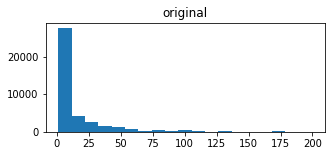

mean: 16.15697299975229 , std: 27.400937056069274


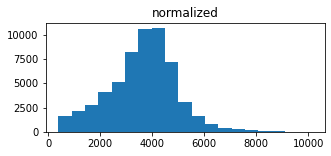

mean: 1.7949903627472572 , std: 1.3861306181784983


In [190]:
df = stf(data['jockey_trainer_1st_1']).replace(0, np.nan)
d = visualize_skew(df)
transformed = np.log(d)
visualize_normal(transformed)

### 2nd - log

skew: 2.802779540602367
skew after log: 0.4123573710016314
skew after sqrt: 1.5655130213088042
skew after cube root: 1.1592075278502705
skew after square: 5.034100765184865


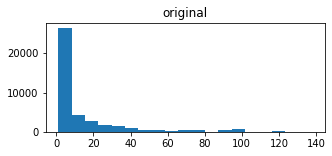

mean: 14.045904041020632 , std: 22.306781952346622


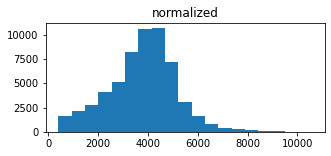

mean: 1.7331409935378588 , std: 1.3282434007477923


In [191]:
df = stf(data['jockey_trainer_2nd_1']).replace(0, np.nan)
d = visualize_skew(df)
transformed = np.log(d)
visualize_normal(transformed)

### 3rd - log

skew: 2.903009477961626
skew after log: 0.40792247736859966
skew after sqrt: 1.579361848593706
skew after cube root: 1.1577198729595422
skew after square: 5.220313184374037


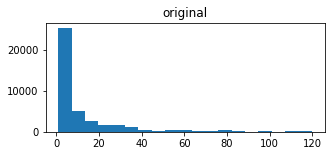

mean: 12.648391991776396 , std: 19.919907179136192


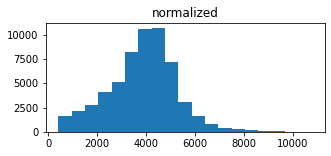

mean: 1.660825726870217 , std: 1.302657655852636


In [192]:
df = stf(data['jockey_trainer_3rd_1']).replace(0, np.nan)
d = visualize_skew(df)
transformed = np.log(d)
visualize_normal(transformed)

## Models

In [49]:
from sklearn.ensemble import RandomForestClassifier

In [57]:
rf = RandomForestClassifier()
rf.fit(Xs['X_train'], y_train)

RandomForestClassifier()

In [58]:
preds = rf.predict(Xs['X_val'])

In [59]:
from sklearn.metrics import confusion_matrix

confusion_matrix(preds, y_val)

array([[6567, 2483],
       [2533, 6661]])